In [1]:
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.layers import Input
from tensorflow.keras import layers
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import json
import help_functions as hf
import numpy as np
import time
# hf.setup_gpu(gpu_nr=1)

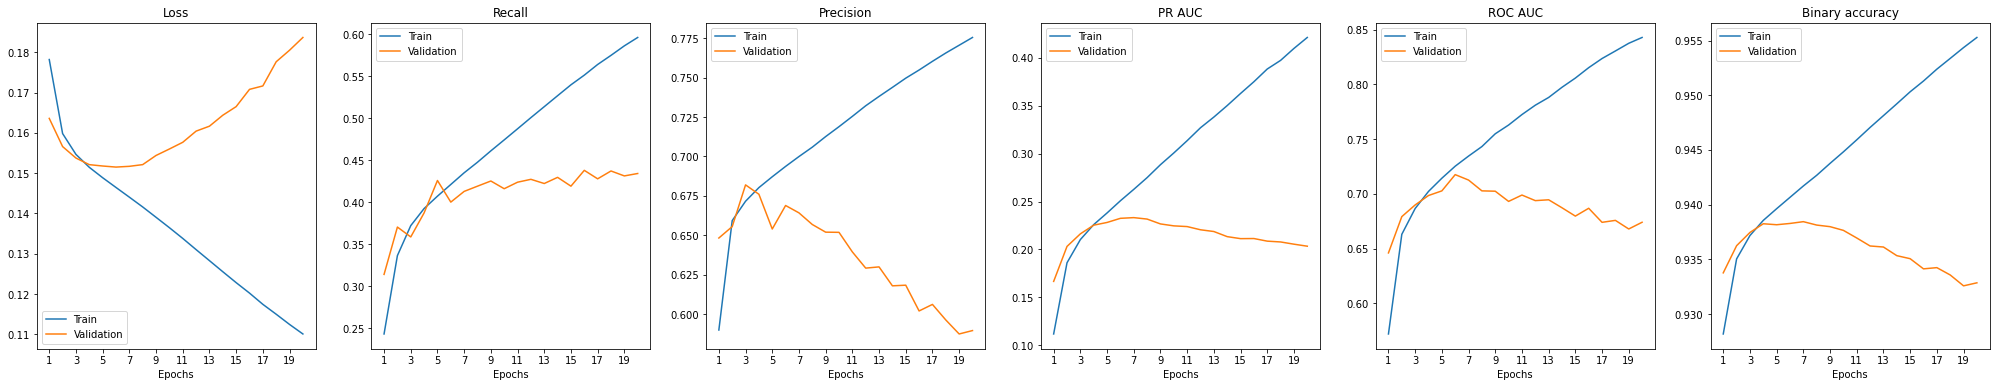

In [12]:
from matplotlib import pyplot as plt
_ = plt.figure(figsize=(35, 6))

with open('training_configurations.json', 'r') as fp:
    config = json.load(fp)[str(109)]
training_metrics = pd.read_csv(config['results_folder'] + '/history.csv')

_ = plt.subplot(1, 6, 1)
plt.plot(range(config['epochs']), training_metrics.loss.values, label='Training loss')
plt.plot(range(config['epochs']), training_metrics.val_loss.values, label='Validation loss')
plt.xlabel('Epochs')
plt.title('Loss')
plt.xticks(np.arange(0, 20, step=2), np.arange(1, 20, step=2))
plt.legend(['Train', 'Validation'])

_ = plt.subplot(1, 6, 2)
plt.plot(range(config['epochs']), training_metrics.recall.values, label='Training recall')
plt.plot(range(config['epochs']), training_metrics.val_recall.values, label='Validation recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.xticks(np.arange(0, 20, step=2), np.arange(1, 20, step=2))
plt.legend(['Train', 'Validation'])

_ = plt.subplot(1, 6, 3)
plt.plot(range(config['epochs']), training_metrics.precision.values, label='Training precision')
plt.plot(range(config['epochs']), training_metrics.val_precision.values, label='Validation precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.xticks(np.arange(0, 20, step=2), np.arange(1, 20, step=2))
plt.legend(['Train', 'Validation'])

_ = plt.subplot(1, 6, 4)
plt.plot(range(config['epochs']), training_metrics.pr_auc.values, label='Training PR_AUC')
plt.plot(range(config['epochs']), training_metrics.val_pr_auc.values, label='Validation PR_AUC')
plt.title('PR AUC')
plt.xlabel('Epochs')
plt.xticks(np.arange(0, 20, step=2), np.arange(1, 20, step=2))
plt.legend(['Train', 'Validation'])

_ = plt.subplot(1, 6, 5)
plt.plot(range(config['epochs']), training_metrics.roc_auc.values, label='Training ROC_AUC')
plt.plot(range(config['epochs']), training_metrics.val_roc_auc.values, label='Validation ROC_AUC')
plt.title('ROC AUC')
plt.xlabel('Epochs')
plt.xticks(np.arange(0, 20, step=2), np.arange(1, 20, step=2))
plt.legend(['Train', 'Validation'])

_ = plt.subplot(1, 6, 6)
plt.plot(range(config['epochs']), training_metrics.binary_accuracy.values, label='Training binary acc')
plt.plot(range(config['epochs']), training_metrics.val_binary_accuracy.values, label='Validation binary acc')
plt.title('Binary accuracy')
plt.xlabel('Epochs')
plt.xticks(np.arange(0, 20, step=2), np.arange(1, 20, step=2))
plt.legend(['Train', 'Validation'])


In [2]:
tf.__version__

'2.3.0'

In [3]:
config_nr = 109
with open('training_configurations.json', 'r') as fp:
    config = json.load(fp)[str(config_nr)]
config['batch_size'] = 32
train, _ = hf.get_flow(df_file=config['data_folder'] + '/test_df.json.bz2',
                       nr_classes=config['nr_classes'],
                       batch_size=config['batch_size'],
                       image_dimension=config['image_dimension'])

val, _ = hf.get_flow(df_file=config['data_folder'] + '/val_stop_df.json.bz2',
                     nr_classes=config['nr_classes'],
                     batch_size=config['batch_size'],
                     image_dimension=config['image_dimension'])

Found 50000 validated image filenames belonging to 31 classes.
Found 50000 validated image filenames belonging to 31 classes.


In [4]:
# M_ij = 1 if the class j is a subclass of the class i. I.e.: row i, column j is 1.
# - note that if M_ij is 1 then M_ji is necessarily 0 as the subclass relation is not reflexive
# - note that M_ij is also 1 if j is not a direct descendant of i (as it is defined in Giunchiglia's model)


#                 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
mask = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 0 Animals
                 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 1 Architecture
                 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 2 Art
                 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 3 Belief
                 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 4 Biology
                 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 5 Chemistry
                 [0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 6 Culture
                 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 7 Earth & Environment
                 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 8 Entertainment
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 9 Events
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 10 Food
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 11 Fossils
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 12 History
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 13 Landscapes
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 14 Literature
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 15 Maps & Flags
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 16 Mathematics
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 17 Medicine & Health
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 18 Music
                 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], # 19 Nature
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 20 People
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 21 Physics
                 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], # 22 Places
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], # 23 Plants
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], # 24 Politics
                 [1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0], # 25 STEM
                 [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1], # 26 Society
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], # 27 Space
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], # 28 Sports
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], # 29 Technology & Engineering
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], # 30 Transportation
                 ], dtype=np.float32)

# import networkx as nx
# import matplotlib.pyplot as plt
# G = nx.from_numpy_matrix(mask)
# plt.figure(figsize=(10, 10))
# label_dict = {v: k for k, v in train.class_indices.items()}
# nx.draw(G, labels=label_dict)

### Try 1
Trying by creating a model class (which is necessary as we want different behaviours when training and when predicting) and then running model.fit. Works, but the loss in model.fit is 0.000. Weird

Inspired in:

In [5]:
loss_tracker = keras.metrics.Mean(name='loss')

class HierarchicalModel(keras.Model):

    def __init__(self, nr_labels, adj_matrix):
        super(HierarchicalModel, self).__init__()
        self.nr_labels = nr_labels
        self.adj_matrix = adj_matrix
        self.basemodel = EfficientNetB2(include_top=False, 
                                        weights=None, 
                                        classes=nr_labels, 
                                        input_shape=(config['image_dimension'], config['image_dimension'], 3))
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(128, activation='relu')
        self.dense_final = layers.Dense(self.nr_labels, activation='sigmoid')

    def call(self, inputs, training=None):
        x = self.basemodel(inputs)
        x = self.flatten(x)
        x = self.dense(x)
        outputs = self.dense_final(x)
        if training:
            return outputs
        else:
            return self.max_constrain(outputs)

    def max_constrain(self, output):
        """
        Constrains the output given the hierarchy expressed by the mask.
        """
        batch_size = tf.shape(output)[0]
        output = tf.expand_dims(output, axis=1) # Pytorch unsqueeze()
        batch_output = tf.broadcast_to(output,            [batch_size, self.nr_labels, self.nr_labels]) # this is H in the MCM equation
        batch_mask   = tf.broadcast_to(self.adj_matrix,   [batch_size, self.nr_labels, self.nr_labels])
        constrained_output = tf.math.reduce_max(batch_output * batch_mask, axis=2)
        return constrained_output

    def train_step(self, data):
        """
        Applies the hierarchy constraint module, calculates the loss function value,
        computes the gradients and optimizes the weights.
        """
        inputs, labels = data # looks to work. printing inputs.numpy().shape gives (512, 64, 64, 3), and labels.numpy().shape gives (512, 31)
        with tf.GradientTape() as tape:
            y_probs = self.call(inputs, training=True)
            y_probs_constrained = (1 - labels) * self.max_constrain(y_probs) + \
                                    labels * self.max_constrain(labels * y_probs)
            # loss_value = bce(labels, y_probs_constrained)
            loss_value = self.compiled_loss(labels, y_probs_constrained)

        # Compute gradients
        trainable_vars = self.trainable_variables
        grads = tape.gradient(loss_value, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(grads, trainable_vars))

        # Update metrics (includes the metric that tracks the loss)
        loss_tracker.update_state(loss_value)
        self.compiled_metrics.update_state(labels, y_probs)
        
        return {m.name: m.result() for m in self.metrics}

In [ ]:
model = HierarchicalModel(nr_labels=len(train.class_indices), adj_matrix=mask)
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='binary_crossentropy', 
              metrics=[
                       tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.5),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.AUC(num_thresholds=50, curve='PR', name='pr_auc', multi_label=True),
                       tf.keras.metrics.AUC(num_thresholds=50, curve='ROC', name='roc_auc', multi_label=True),
                       tf.keras.metrics.FalseNegatives(name='fn'),
                       tf.keras.metrics.FalsePositives(name='fp'),
                       tf.keras.metrics.TrueNegatives(name='tn'),
                       tf.keras.metrics.TruePositives(name='tp'),
                       ])
history = model.fit(train, epochs=100, steps_per_epoch=20, validation_steps=20, validation_data=val) 


Time passed: 0.15 hours


Text(0.5, 1.0, 'TP')

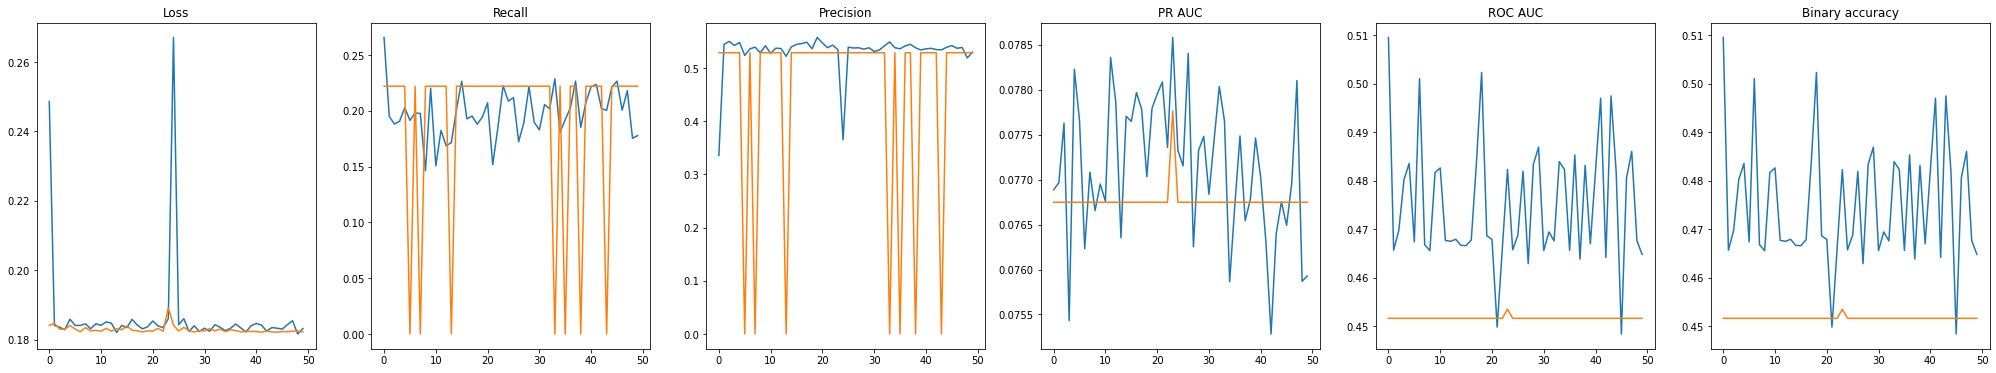

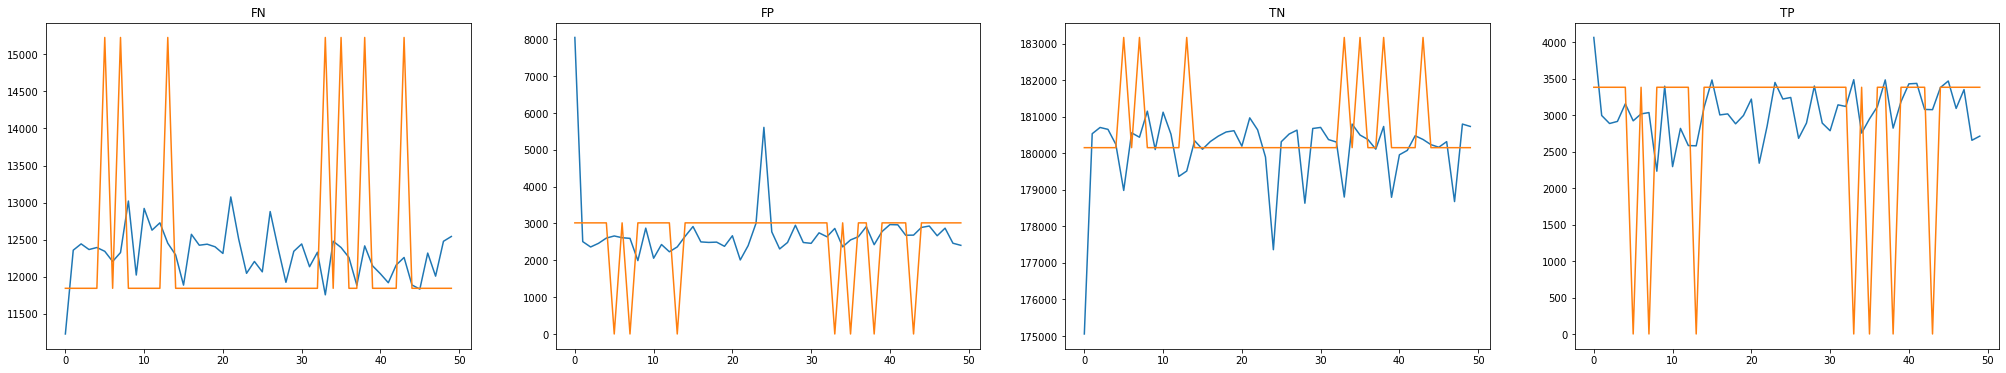

In [12]:
from matplotlib import pyplot as plt

_ = plt.figure(figsize=(35, 6))

_ = plt.subplot(1, 6, 1)
plt.plot(range(40), history.history['loss'])
plt.plot(range(40), history.history['val_loss'])
plt.title('Loss')

_ = plt.subplot(1, 6, 2)
plt.plot(range(40), history.history['recall'])
plt.plot(range(40), history.history['val_recall'])
plt.title('Recall')

_ = plt.subplot(1, 6, 3)
plt.plot(range(40), history.history['precision'])
plt.plot(range(40), history.history['val_precision'])
plt.title('Precision')

_ = plt.subplot(1, 6, 4)
plt.plot(range(40), history.history['pr_auc'])
plt.plot(range(40), history.history['val_pr_auc'])
plt.title('PR AUC')

_ = plt.subplot(1, 6, 5)
plt.plot(range(40), history.history['roc_auc'])
plt.plot(range(40), history.history['val_roc_auc'])
plt.title('ROC AUC')

_ = plt.subplot(1, 6, 6)
plt.plot(range(40), history.history['roc_auc'])
plt.plot(range(40), history.history['val_roc_auc'])
plt.title('Binary accuracy')

_ = plt.figure(figsize=(35, 6))

_ = plt.subplot(1, 4, 1)
plt.plot(range(40), history.history['fn'])
plt.plot(range(40), history.history['val_fn'])
plt.title('FN')

_ = plt.subplot(1, 4, 2)
plt.plot(range(40), history.history['fp'])
plt.plot(range(40), history.history['val_fp'])
plt.title('FP')

_ = plt.subplot(1, 4, 3)
plt.plot(range(40), history.history['tn'])
plt.plot(range(40), history.history['val_tn'])
plt.title('TN')

_ = plt.subplot(1, 4, 4)
plt.plot(range(40), history.history['tp'])
plt.plot(range(40), history.history['val_tp'])
plt.title('TP')

In [7]:
history.history

NameError: name 'history' is not defined

### Try 2
This works but doesn't give the expected behaviour since training and predicting need to have different behaviours. If we do it this way then we can't control what happens when calling model(input).

Inspired in:

In [ ]:
# -------------------------------- Define model
nr_labels = len(train.class_indices)
basemodel = EfficientNetB2(include_top=False, weights=None, classes=nr_labels, input_shape=(config['image_dimension'], config['image_dimension'], 3))
inputs = Input(shape=(config['image_dimension'], config['image_dimension'], 3))
x = basemodel(inputs)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(nr_labels, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])



# --------------------------------- Training functions
@tf.function
def max_constrain(output, mask):
    """
    Constrains the output given the hierarchy expressed by the mask.
    """

    batch_size = len(output) # or output.shape[0]

    output = tf.expand_dims(output, axis=1) # Pytorch unsqueeze()

    batch_output = tf.broadcast_to(output, [batch_size, nr_labels, nr_labels]) # this is H in the MCM equation
    batch_mask   = tf.broadcast_to(mask,   [batch_size, nr_labels, nr_labels])

    constrained_output = tf.math.reduce_max(batch_output * batch_mask, axis=2)

    return constrained_output

@tf.function   # to speed up: https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch#speeding-up_your_training_step_with_tffunction
def train_step(inputs, labels, mask):
    """
    Applies the hierarchy constraint module, calculates the loss function value,
    computes the gradients and optimizes the weights.
    """

    # print(f'INPUTS: \n{inputs}')
    # print(f'LABELS: \n{labels}')

    with tf.GradientTape() as tape:
        y_probs = model(inputs, training=True)

        # Extra steps for coherent HMC:
        # 1. max constraint module        
        # term_1 = (1 - labels) * max_constrain(y_probs, mask)
        # term_2 = labels * max_constrain(labels * y_probs, mask)
        # y_probs_constrained = term_1 + term_2
        y_probs_constrained = (1 - labels) * max_constrain(y_probs, mask) + labels * max_constrain(labels * y_probs, mask)

        # 2. modify what is sent to binary cross-entropy function
        loss_value = model.compiled_loss(labels, y_probs_constrained)

    grads = tape.gradient(loss_value, model.trainable_weights)
    
    return loss_value, grads



# ----------------------------------------- Training loop 
epochs = 2
steps_per_epoch_train = len(train.classes) // config['batch_size'] + 1
steps_per_epoch_val = len(val.classes) // config['batch_size'] + 1
print(f'steps_per_epoch_train: {steps_per_epoch_train}.')
print(f'steps_per_epoch_val: {steps_per_epoch_val}.')
mask_tf = tf.convert_to_tensor(mask)

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(epochs):
    print(f'Start of epoch {epoch}\n')
    end = time.time()

    train_loss = tf.metrics.Mean('train_loss')
    train_acc = tf.metrics.CategoricalAccuracy('train_accuracy')
    val_loss = tf.metrics.Mean('val_loss')
    val_acc = tf.metrics.CategoricalAccuracy('val_accuracy')
    
    for step, (x_batch_train, y_batch_train) in enumerate(train):
        if step >= 22:
        # if step >= steps_per_epoch_train:
            break
        # Calculate loss and gradients, then optimize parameters
        loss, grads = train_step(x_batch_train, y_batch_train, mask_tf)
        model.optimizer.apply_gradients(zip(grads, model.trainable_weights))

        train_loss.update_state(loss)
        train_acc.update_state(y_batch_train, model(x_batch_train, training=True))

        # Progress logging
        if step % 10 == 0:
            print(f"Training loss (for one batch) at step {step}: {float(loss):.4f}")
            print(f"Seen so far: {(step + 1) * config['batch_size']} samples")
            temp_end = time.time()
            print(f'time: {np.round((temp_end-end) / 60, 2)} minutes')
            end = time.time()      
        

    # Evaluate on validation set
    print('Evaluating on validation set...')
    for step, (x_batch_val, y_batch_val) in enumerate(val):
        if step >= 22:
        # if step >= steps_per_epoch_val:
            break
        loss, _ = train_step(x_batch_val, y_batch_val, mask_tf)
        val_loss.update_state(loss)
        val_acc.update_state(y_batch_val, model(x_batch_val, training=False))
    
    train_losses.append(train_loss.result().numpy())
    train_accs.append(train_acc.result().numpy())
    val_losses.append(val_loss.result().numpy())
    val_accs.append(val_acc.result().numpy())

    print(f'Epoch {epoch}, Loss: {train_losses[-1]:.4f}, Accuracy: {100*train_accs[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {100*val_accs[-1]:.2f}%')

    # Reset training metrics at the end of each epoch
    train_loss.reset_states()
    train_acc.reset_states()
    val_loss.reset_states()
    val_acc.reset_states()

In [ ]:
d = {'epoch': list(range(0, epochs)), 
     'accuracy': train_accs, 
     'loss': train_losses, 
     'val_accuracy': val_accs, 
     'val_loss': val_losses}
df = pd.DataFrame(data=d)
df.to_csv('history.csv', index=False)

#### Unit tests of the Maximum Constraint Module

In [ ]:
# Unit test of maximum constraint module: 3 classes
# Class 1 is the parent of classes 2 and 3
mask = np.array([[1, 0, 0],
                 [1, 1, 0],
                 [1, 0, 1]], dtype=np.float32)
np.fill_diagonal(mask, 1)
mask = np.transpose(mask)

# Case 1: the parent has greater probability than both children. Nothing changes.
probs = np.array([[0.7, 0.5, 0.2]], dtype=np.float32)
assert((max_constrain(probs, mask)[0].numpy() == probs).all())

# Case 2: the parent has smaller probability than child class 2. 
probs = np.array([[0.1, 0.5, 0.2]], dtype=np.float32)
assert((max_constrain(probs, mask)[0].numpy() == np.array([0.5, 0.5, 0.2], dtype=np.float32)).all())

# Case 3: the parent has smaller probability than child class 3. 
probs = np.array([[0.1, 0.3, 0.8]], dtype=np.float32)
assert((max_constrain(probs, mask)[0].numpy() == np.array([0.8, 0.3, 0.8], dtype=np.float32)).all())

# Case 4: the parent has smaller probability than both children. 
probs = np.array([[0.2, 0.3, 0.5]], dtype=np.float32)
assert((max_constrain(probs, mask)[0].numpy() == np.array([0.5, 0.3, 0.5], dtype=np.float32)).all())

# Unit test of maximum constraint module: 5 classes
#     1  2
#    / \  \
#   3   4  5
# Class 1 is the parent of classes 3 and 4; class 2 is the parent of class 5
mask = np.array([[1, 0, 1, 1, 0],
                 [0, 1, 0, 0, 1],
                 [0, 0, 1, 0, 0],
                 [0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 1],], dtype=np.float32)

# Case 1: all is good (1 has great prob than 3 and 4; 2 has greater prob than 5)
probs = np.array([[0.7, 0.5, 0.2, 0.1, 0.1]], dtype=np.float32)
assert((max_constrain(probs, mask)[0].numpy() == probs).all())

# Case 2: 1 has smaller prob than 3; 2 is ok
probs = np.array([[0.7, 0.5, 0.9, 0.1, 0.1]], dtype=np.float32)
assert((max_constrain(probs, mask)[0].numpy() == np.array([0.9, 0.5, 0.9, 0.1, 0.1], dtype=np.float32)).all())

# Case 3: 1 has smaller prob than 4; 2 is ok
probs = np.array([[0.7, 0.5, 0.6, 0.9, 0.1]], dtype=np.float32)
assert((max_constrain(probs, mask)[0].numpy() == np.array([0.9, 0.5, 0.6, 0.9, 0.1], dtype=np.float32)).all())

# Case 4: 1 has smaller prob than 4; 2 has smaller prob than 5
probs = np.array([[0.7, 0.5, 0.6, 0.9, 0.8]], dtype=np.float32)
assert((max_constrain(probs, mask)[0].numpy() == np.array([0.9, 0.8, 0.6, 0.9, 0.8], dtype=np.float32)).all())

def get_parent_child_dict(mask):
    dict = {}
    for row_idx in range(mask.shape[0]):
        children_idx = np.nonzero(mask[row_idx, :])[0]
        if children_idx.size:
            dict[row_idx] = children_idx
    return dict

def is_coherent(probs, parent_idx, children_idx):
    for child_idx in children_idx:
        assert(probs[parent_idx] >= probs[child_idx])

def coherence_test(mask, nr_tests=100):
    parent_child_dict = get_parent_child_dict(mask)
    for _ in range(nr_tests):
        probs = np.random.uniform(low=0.0, high=1.0, size=(1, mask.shape[0]))
        probs = np.array(probs, dtype=np.float32)
        coherent_probs = max_constrain(probs, mask)[0] # '0' because the output of max_constrain is a copy of the same coherent probs in several lines
        for parent_idx in parent_child_dict:
            is_coherent(coherent_probs, parent_idx, parent_child_dict[parent_idx])  
    print('Test passed, all probs are coherent!')

# -------------------- Tress with 2 layers

#   1   2
#  / \   \
# 3   4   5
mask = np.array([[1, 0, 1, 1, 0],
                 [0, 1, 0, 0, 1],
                 [0, 0, 1, 0, 0],
                 [0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 1],], dtype=np.float32)

coherence_test(mask)    

#     1
#  / / \ \
# 2 3  4  5
mask = np.array([[1, 1, 1, 1, 1],
                 [0, 1, 0, 0, 0],
                 [0, 0, 1, 0, 0],
                 [0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 1],], dtype=np.float32)

coherence_test(mask)   

#  1        5     8 
# / \ \    / \   / \
# 2 3  4  6   7  9  10
mask = np.array([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
                 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
                 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],], dtype=np.float32)

coherence_test(mask) 

# -------------------- Tress with 3 or more layers

# 1
# |
# 2
# |
# 3
mask = np.array([[1, 1, 1],
                 [0, 1, 1],
                 [0, 0, 1]], dtype=np.float32)
coherence_test(mask)

#     1    5
#    / \   |
#   2   3  6
#  /       |
# 4        7
mask = np.array([[1, 1, 1, 1, 0, 0, 0],
                 [0, 1, 0, 1, 0, 0, 0],
                 [0, 0, 1, 0, 0, 0, 0],
                 [0, 0, 0, 1, 0, 0, 0],
                 [0, 0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 0, 0, 1, 1],
                 [0, 0, 0, 0, 0, 0, 1],], dtype=np.float32)
coherence_test(mask)

#### Unit tests of the loss function
Compare the result with the official PyTorch implementation. Indeed the same result!

In [ ]:
mask = np.array([[1, 0, 1, 1, 0],
                 [0, 1, 0, 0, 1],
                 [0, 0, 1, 0, 0],
                 [0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 1],], dtype=np.float32)
                 
# y_probs = np.array([[0.35, 0.03, 0.6, 0.08, 0.1],
#                     [0.9, 0.03, 0.05, 0.98, 0.01],
#                     [0.57, 0.33, 0.7, 0.2, 0.12]], dtype=np.float32)

y_probs = np.array([[0.35, 0.03, 0.6, 0.08, 0.1]], dtype=np.float32)

labels = np.array([[0, 0, 1, 0, 1]], dtype=np.float32)


term_1 = (1 - labels) * max_constrain(y_probs, mask)
term_2 = labels * max_constrain(labels * y_probs, mask)
y_probs_constrained = term_1 + term_2

bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
bce(labels, y_probs_constrained).numpy()

0.7836884